In [1]:
# Copyright (c) 2024 Graphcore Ltd. All rights reserved.
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import numpy as np
from gfloat import *
from gfloat.formats import format_info_ocp_e5m2

# Abbreviate RoundMode printing just for this notebook, for figure legends
if "RoundMode__str__" not in locals():
    RoundMode__str__ = RoundMode.__str__
    RoundMode.__str__ = lambda x: RoundMode__str__(x).replace(
        "RoundMode.Stochastic", "SR"
    )

    assert str(RoundMode.StochasticFast) == "SRFast"

# Stochastic rounding

This notebook does some simple experiments with stochastic rounding.

Let's see examples of stochastic rounding and the default round-to-nearest for 
some input values in an 8-bit float range. 

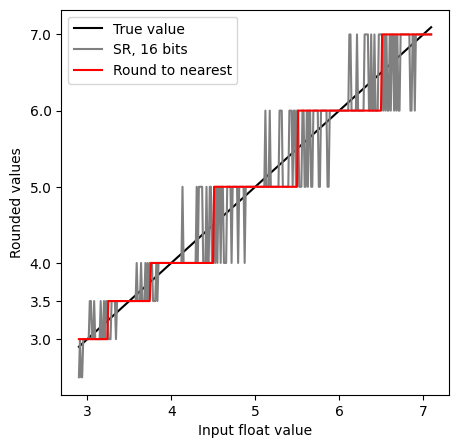

In [13]:
fi = format_info_ocp_e5m2  # A common P3 format

vs = np.arange(2.9, 7.1, 1 / 77)
# Round to nearest
rn = round_ndarray(fi, vs)
err_rn = np.abs(rn - vs).mean()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(vs, vs, label="True value", color="k")

# Stochastic rounding
srnumbits = 16
srbits = np.random.randint(0, 2**srnumbits, len(vs))

rvs = round_ndarray(
    fi, vs, RoundMode.Stochastic, sat=False, srbits=srbits, srnumbits=srnumbits
)
color = "gray"
ax.plot(vs, rvs, label=f"SR, {srnumbits} bits", color=color)

ax.plot(vs, rn, label=f"Round to nearest", color="red")
ax.set_xlabel("Input float value")
ax.set_ylabel(f"Rounded values")
ax.set_yticks(np.unique(rn))
ax.legend()
None

The black $Y=X$ curve plots the input real value, the red curve shows that value 
rounded to the nearest representable value in the chosen float format, 
and the grey curve shows stochastic rounding, again to a nearest representable value,
but randomly up or down depending how close the input value is to the next highest 
and lowest representable values.  By squinting, one might persuade oneself it is more 
uppish to the right of the black line and more downish to the left, but it's not really
visible to the eye.

In order to get a better idea of the behaviour, we will change the plot to show the 
average rounded value at each input real value.  At 16 bits of randomness, 
this almost appears too good to be true:

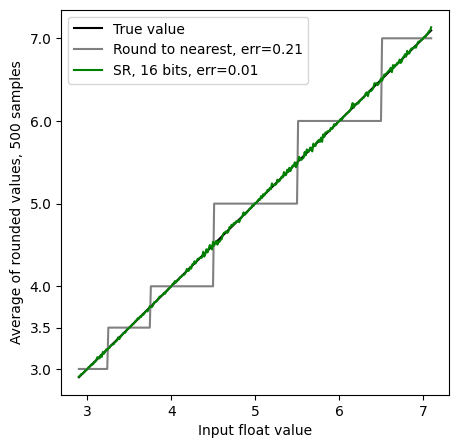

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(vs, vs, label="True value", color="k")
ax.plot(vs, rn, label=f"Round to nearest, err={err_rn:.2f}", color="gray")

# Stochastic rounding
srnumbits = 16
nsamples = 500
srbits = np.random.randint(0, 2**srnumbits, (nsamples, len(vs)))

rvs = round_ndarray(
    fi,
    vs[np.newaxis, :],
    RoundMode.Stochastic,
    sat=False,
    srbits=srbits,
    srnumbits=srnumbits,
)
rvmean = rvs.mean(axis=0)
err = np.abs(rvmean - vs).mean()
color = "green"
ax.plot(
    vs,
    rvmean,
    label=f"SR, {srnumbits} bits, err={err:.2f}",
    color=color,
)

ax.set_xlabel("Input float value")
ax.set_ylabel(f"Average of rounded values, {nsamples} samples")
ax.set_yticks(np.unique(rn))
ax.legend()
None

The green line is pretty much on top of the true value (some small random 
deviations are evident), indicating that with 500 samples, 
the stochastically rounded value is on average very accurate.

Before we go further, let's zoom in a bit:

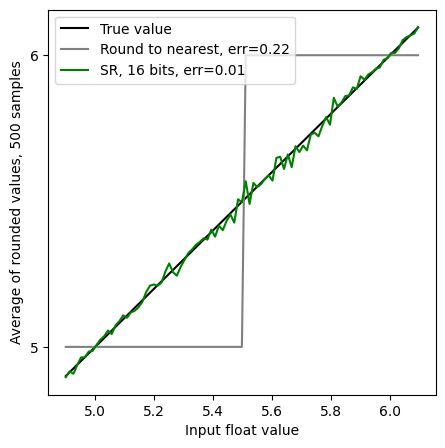

In [15]:
vs = np.arange(4.9, 6.1, 1 / 77)
# Round to nearest
rn = round_ndarray(fi, vs)
err_rn = np.abs(rn - vs).mean()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(vs, vs, label="True value", color="k")
ax.plot(vs, rn, label=f"Round to nearest, err={err_rn:.2f}", color="gray")

# Stochastic rounding
srnumbits = 16
nsamples = 500
srbits = np.random.randint(0, 2**srnumbits, (nsamples, len(vs)))

rvs = round_ndarray(
    fi,
    vs[np.newaxis, :],
    RoundMode.Stochastic,
    sat=False,
    srbits=srbits,
    srnumbits=srnumbits,
)
rvmean = rvs.mean(axis=0)
err = np.abs(rvmean - vs).mean()
color = "green"
ax.plot(
    vs,
    rvmean,
    label=f"SR, {srnumbits} bits, err={err:.2f}",
    color=color,
)

ax.set_xlabel("Input float value")
ax.set_ylabel(f"Average of rounded values, {nsamples} samples")
ax.set_yticks(np.unique(rn))
ax.legend()
None

That's a bit jaggier, reassuringly, but still shows good agreement between SR 
and infinite precision.

As mentioned above, however, one may have fewer random bits available in a real-world
system, so let's see what happens with 2 bits of randomness:

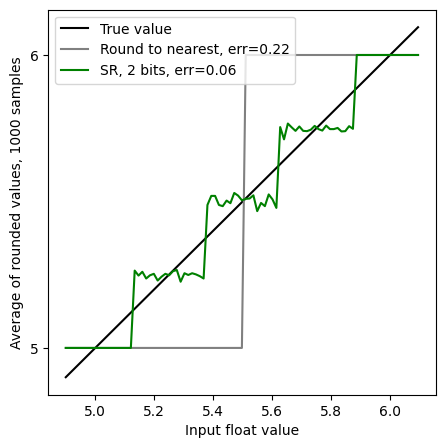

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(vs, vs, label="True value", color="k")
ax.plot(vs, rn, label=f"Round to nearest, err={err_rn:.2f}", color="gray")

# Stochastic rounding
srnumbits = 2
nsamples = 1_000
srbits = np.random.randint(0, 2**srnumbits, (nsamples, len(vs)))

rvs = round_ndarray(
    fi,
    vs[np.newaxis, :],
    RoundMode.Stochastic,
    sat=False,
    srbits=srbits,
    srnumbits=srnumbits,
)
rvmean = rvs.mean(axis=0)
err = np.abs(rvmean - vs).mean()
color = "green"
ax.plot(
    vs,
    rvmean,
    label=f"SR, {srnumbits} bits, err={err:.2f}",
    color=color,
)

ax.set_xlabel("Input float value")
ax.set_ylabel(f"Average of rounded values, {nsamples} samples")
ax.set_yticks(np.unique(rn))
ax.legend()
None

We still have the green line is closer to the black Y=X line than the grey line is,
but now we all see the clear step effect, due to the limited number of SR bits.

As a mental shorthand, we might consider that SR has given us extra precision 
corresponding to the number of `srbits`.
Here, with `srbits = 2`, it's as if we are performing round-to-nearest in a 10-bit 
P5 format rather than an 8-bit P3 one.  Let's just quickly simulate that.
We will make a format like `format_info_ocp_e5m2`, but increase the 
bitwidth and precision:


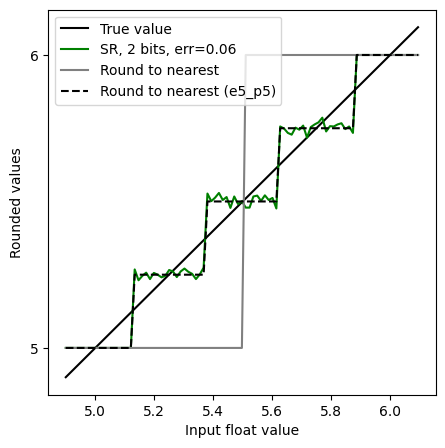

In [17]:
# Make FormatInfo for a putative P5 format with the same exponent range as E5M2
fi_p5 = FormatInfo(
    name="e5_p5",
    k=10,
    precision=5,
    emax=15,
    has_nz=True,
    has_infs=True,
    num_high_nans=2**4 - 1,
    has_subnormals=True,
    is_signed=True,
    is_twos_complement=False,
)

# Round to nearest in P5
rn_p5 = round_ndarray(fi_p5, vs)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(vs, vs, label="True value", color="k")

# Stochastic rounding
srnumbits = 2
nsamples = 1_000
srbits = np.random.randint(0, 2**srnumbits, (nsamples, len(vs)))

rvs = round_ndarray(
    fi,
    vs[np.newaxis, :],
    RoundMode.Stochastic,
    sat=False,
    srbits=srbits,
    srnumbits=srnumbits,
)
rvmean = rvs.mean(axis=0)
err = np.abs(rvmean - vs).mean()
color = "green"
ax.plot(
    vs,
    rvmean,
    label=f"SR, {srnumbits} bits, err={err:.2f}",
    color=color,
)

ax.plot(vs, rn, label=f"Round to nearest", color="gray")
ax.plot(vs, rn_p5, label=f"Round to nearest ({fi_p5})", color="black", linestyle="--")
ax.set_xlabel("Input float value")
ax.set_ylabel(f"Rounded values")
ax.set_yticks(np.unique(rn))
ax.legend()
None

And we can observe that the black dashed line and green noisy line follow each other.
That is, with enough samples, 2 bits of stochastic rounding can be thought of as being
akin to having 2 extra bits of precision.

## Some implementation subtleties

In existing implementations of SR, a number of subtleties arise,
which it may be instructive to observe using the `gfloat` implementation.

Typically, in high-school rounding, we implement round-to-nearest with code like
```py
def round(x):
  return floor(x + 0.5)
```

Explanations of stochastic rounding often motivate it by replacing "0.5" with a 
random number between 0 and 1:
```py
def round_stochastic(x):
  return floor(x + rand())
```

This is a correct definition when `x` and `rand()` work in infinite precision, 
but needs to change subtly when they are supplied in fixed precision, as is true 
in a floating point system.

Let's assume that `rand()` produces only `S` bits of randomness at every call,
i.e. that its implementation is something like
```py
def rand(S):
  bits = randint(2**S) # Draw a random S-bit integer (assume this is perfectly random)
  return bits * 2**-S # Return a float in [0, 1)
```
so that SR looks like:
```py
def round_stochastic(x):
  bits = randint(2**S) # Draw a random S-bit integer
  return floor(x + bits * 2**-S)
```
This is essentially gfloat's `StochasticFast` implementation.
Let's see how it does, compared to the default implementation:

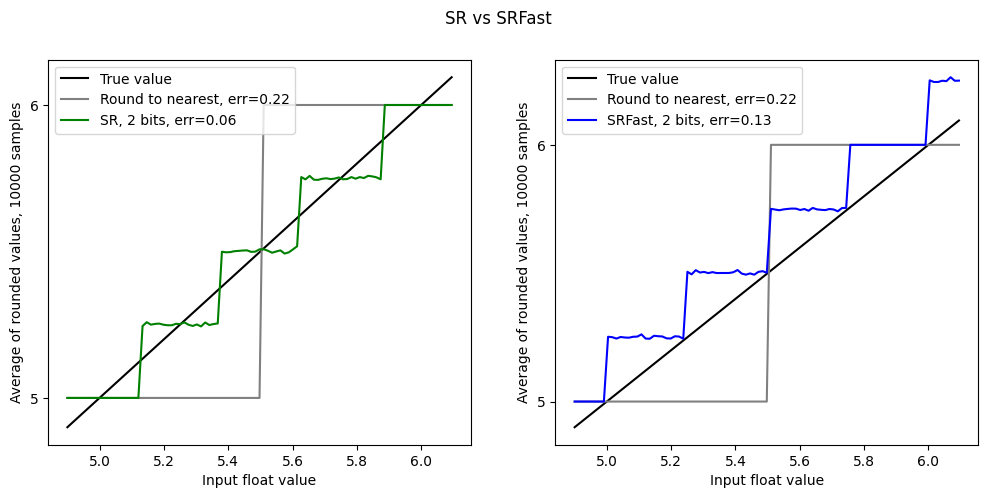

In [18]:
fi = format_info_ocp_e5m2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("SR vs SRFast")

for rnd in (RoundMode.Stochastic, RoundMode.StochasticFast):
    SR = rnd == RoundMode.StochasticFast
    ax = ax1 if not SR else ax2
    ax.plot(vs, vs, label="True value", color="k")
    ax.plot(vs, rn, label=f"Round to nearest, err={err_rn:.2f}", color="gray")

    # Stochastic rounding
    srnumbits = 2
    nsamples = 10_000
    srbits = np.random.randint(0, 2**srnumbits, (nsamples, len(vs)))

    rvs = round_ndarray(
        fi, vs[np.newaxis, :], rnd, sat=False, srbits=srbits, srnumbits=srnumbits
    )
    rvmean = rvs.mean(axis=0)
    err = np.abs(rvmean - vs).mean()
    color = "blue" if SR else "green"
    ax.plot(
        vs,
        rvmean,
        label=f"{'SRFast' if SR else 'SR'}, {srnumbits} bits, err={err:.2f}",
        color=color,
    )

    ax.set_xlabel("Input float value")
    ax.set_ylabel(f"Average of rounded values, {nsamples} samples")
    ax.set_yticks(np.unique(rn))
    ax.legend()
None

Yikes!  The right-hand line is not symmetric around $Y=X$.
Note that it is still rounding as if to two extra bits of precision,
but there is a bias towards positive values.

To visualize the difference between "Stochastic" and "StochasticFast" rounding, let's
plot the rounding for a densely sampled set of values between two floats.

In OCP E5M2 format, the values 5 and 6 are adjacent floats.  Under NearestTiesToEven,
all values below 5.5 round to 5, the other values to 6.

We would plot this "rounding profile" as follows:

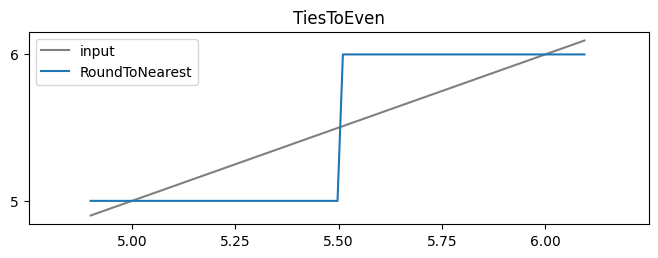

In [19]:
fig, ax = plt.subplots(figsize=(8, 2.5))
r = round_ndarray(fi, vs, RoundMode.TiesToEven)
ax.plot(vs, vs, label=f"input", color="gray")
ax.plot(vs, r, label=f"RoundToNearest")
ax.set_xlim(4.75, 6.25)
ax.set_xticks(np.linspace(5, 6, 5))
ax.set_yticks([5, 6])
ax.legend()
ax.set_title(f"TiesToEven")
None

To consider the behaviour of stochastic rounding, think of it as selecting a random 
rounding profile based on the set of stochastic rounding bits.  Let us plot those 
profiles for SRNumBits=2, so there are four profiles.

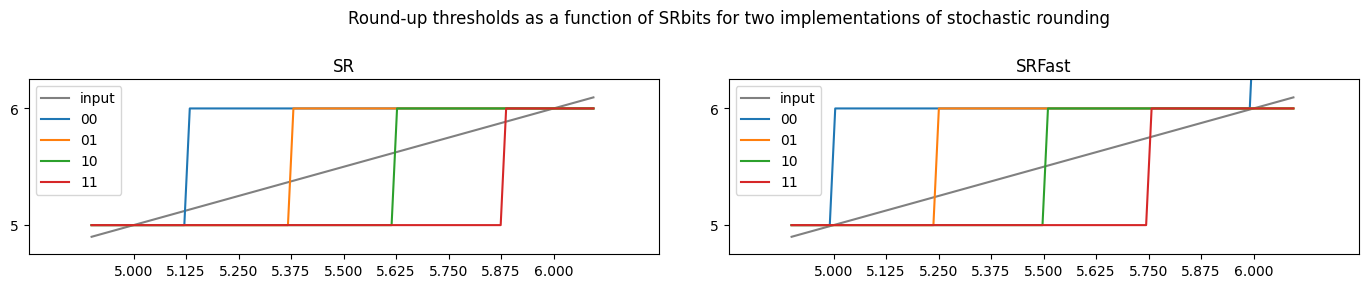

In [20]:
fig = plt.figure(figsize=(14, 2.5))
fig.suptitle(
    "Round-up thresholds as a function of SRbits for two implementations of stochastic rounding"
)
h = 0.7
axs = fig.add_axes((0, 0, 0.45, h)), fig.add_axes((0.5, 0, 0.45, h))
for rnd, ax in zip((RoundMode.Stochastic, RoundMode.StochasticFast), axs):
    ax.plot(vs, vs, label=f"input", color="gray")

    srnumbits = 2
    for srbits in range(2**srnumbits):
        r = round_ndarray(
            fi,
            vs,
            rnd,
            sat=False,
            srbits=np.full(vs.shape, srbits),
            srnumbits=srnumbits,
        )
        ax.plot(vs, r, label=f"{srbits:02b}")
    ax.set_xlim(4.75, 6.25)
    ax.set_ylim(4.75, 6.25)
    ax.set_xticks(np.linspace(5, 6, 9))
    ax.set_yticks([5, 6])
    ax.legend()
    ax.set_title(f"{rnd}")
None

We can see that in `SRFast`, rounding up begins immediately after 5.0, that is, for SRBits = 00, all values above 5.0 are rounded to 6.0.

The first fix one might try is to add an extra half bit to SRBits.

From:
```py
def round_stochastic(x):
  bits = randint(2**S) # Draw a random S-bit integer
  return floor(x + bits * 2**-S)
```

To:
```py
def round_stochastic2(x):
  bits = randint(2**S) # Draw a random S-bit integer
  return floor(x + (bits + 0.5) * 2**-S)
```

This is essentially what is done in the mode called `RoundMode.StochasticNearly`.
Let's see if it works...

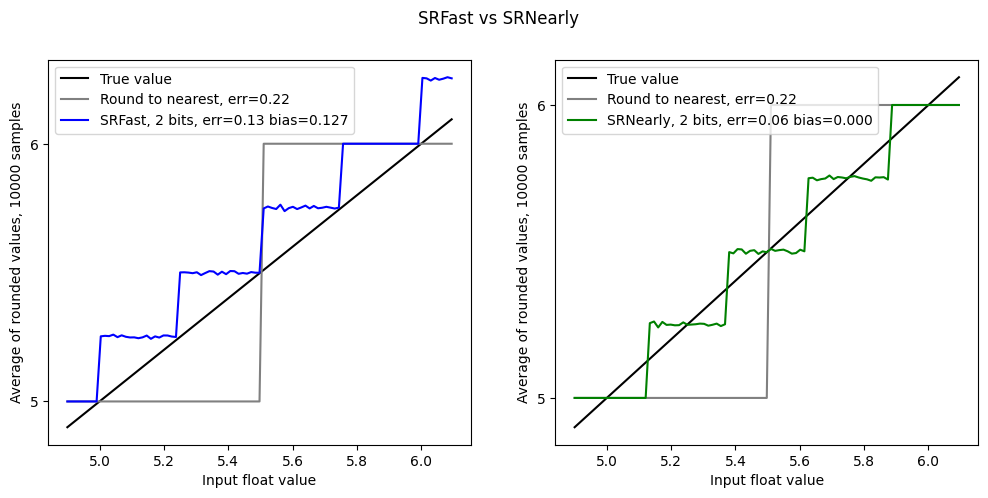

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs = axs.T
fig.suptitle("SRFast vs SRNearly")

for rnd in (RoundMode.StochasticFast, RoundMode.StochasticNearly):
    SR = rnd == RoundMode.StochasticFast
    ax = axs[0] if SR else axs[1]
    ax.plot(vs, vs, label="True value", color="k")
    ax.plot(vs, rn, label=f"Round to nearest, err={err_rn:.2f}", color="gray")

    # Stochastic rounding
    srnumbits = 2
    nsamples = 10_000
    srbits = np.random.randint(0, 2**srnumbits, (nsamples, len(vs)))

    rvs = round_ndarray(
        fi, vs[np.newaxis, :], rnd, sat=False, srbits=srbits, srnumbits=srnumbits
    )
    rvmean = rvs.mean(axis=0)
    err = np.abs(rvmean - vs).mean()
    bias = (rvmean - vs).mean()
    color = "blue" if SR else "green"
    ax.plot(
        vs,
        rvmean,
        label=f"{'SRFast' if SR else 'SRNearly'}, {srnumbits} bits, {err=:.2f} {bias=:.3f}",
        color=color,
    )

    ax.set_xlabel("Input float value")
    ax.set_ylabel(f"Average of rounded values, {nsamples} samples")
    ax.set_yticks(np.unique(rn))
    ax.legend()
None

OK, so `SRNearly` seems to have fixed things...  What could be wrong?

The answer is that we are still modelling the inputs `v` as being infinite precision
(well, they are float64 here, but that's pretty much infinite precision).

If we first assume that they are available in some finite precision, 
still larger than that to which we are effectively rounding, then we obtain another,
relatively small, bias.

Let's add some lines to the above...

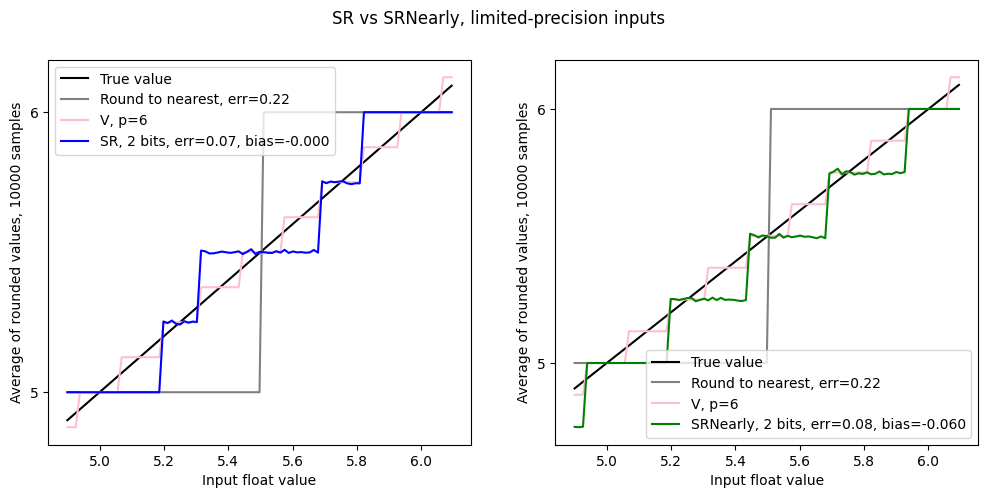

In [23]:
# Make FormatInfo for a putative E5M6 format
highp = fi.precision + 3
fi_p9 = FormatInfo(
    name=f"e5m{highp-1}",
    k=5 + highp,
    precision=highp,
    emax=15,
    has_nz=True,
    has_infs=True,
    num_high_nans=2 ** (highp - 1) - 1,
    has_subnormals=True,
    is_signed=True,
    is_twos_complement=False,
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("SR vs SRNearly, limited-precision inputs")

for rnd, ax in zip((RoundMode.Stochastic, RoundMode.StochasticNearly), axes):
    ax.plot(vs, vs, label="True value", color="k")
    ax.plot(vs, rn, label=f"Round to nearest, err={err_rn:.2f}", color="gray")

    # Stochastic rounding
    srnumbits = 2
    nsamples = 10_000
    srbits = np.random.randint(0, 2**srnumbits, (nsamples, len(vs)))

    # The infinite-precision vs, but computed to `highp` bits of precision
    vs_p9 = round_ndarray(fi_p9, vs, RoundMode.TiesToEven)

    rvs = round_ndarray(
        fi, vs_p9[np.newaxis, :], rnd, sat=False, srbits=srbits, srnumbits=srnumbits
    )
    rvmean = rvs.mean(axis=0)
    err = np.abs(rvmean - vs).mean()
    bias = (rvmean - vs).mean()
    color = "blue" if ax == axes[0] else "green"
    ax.plot(
        vs,
        vs_p9,
        label=f"V, p={fi_p9.precision}",
        color="pink",
    )
    ax.plot(
        vs,
        rvmean,
        label=f"{rnd}, {srnumbits} bits, {err=:.2f}, {bias=:.3f}",
        color=color,
    )

    ax.set_xlabel("Input float value")
    ax.set_ylabel(f"Average of rounded values, {nsamples} samples")
    ax.set_yticks(np.unique(rn))
    ax.legend()
None

So...  The blue (left) curve has no bias, and also happens to exhibit clear RTNE behaviour; the green (right) curve shows the bias inherent in the assumption that the inputs are all computed to infinite precision, despite the inputs themselves exhibiting no bias.